## Merge 2 dataset (weather + energy)

In [1]:
import pandas as pd
import numpy as np

In [2]:
energy23_data = pd.read_csv('demanddata_2023.csv')
energy24_data = pd.read_csv('demanddata_2024.csv')
energy25_data = pd.read_csv('demanddata_2025.csv') 
weather_data = pd.read_csv('london_2023_25_halfhour_interp.csv')

energy_data = pd.concat([energy23_data, energy24_data, energy25_data], ignore_index=True)

# convert time columns
energy_data['SETTLEMENT_DATE'] = pd.to_datetime(energy_data['SETTLEMENT_DATE'])
weather_data['time'] = pd.to_datetime(weather_data['time'])

# create full datetime for energy half-hour periods
energy_data['datetime'] = energy_data['SETTLEMENT_DATE'] + pd.to_timedelta((energy_data['SETTLEMENT_PERIOD'] - 1) * 30, unit='min')

start_date = pd.to_datetime("2023-01-01")
end_date   = pd.to_datetime("2025-10-31")

energy_data = energy_data[
    (energy_data['datetime'] >= start_date) &
    (energy_data['datetime'] <= end_date)
]

weather_data = weather_data[
    (weather_data['time'] >= start_date) &
    (weather_data['time'] <= end_date)
]

# merge after filtering
merged_data = pd.merge(
    energy_data,
    weather_data,
    left_on='datetime',
    right_on='time',
    how='inner'
)

# save output
merged_data.to_csv('merged_energy_weather_data.csv', index=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6352\614154498.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  energy_data['SETTLEMENT_DATE'] = pd.to_datetime(energy_data['SETTLEMENT_DATE'])


In [3]:
#get data
df=pd.read_csv('merged_energy_weather_data.csv')

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['year'] = df['datetime'].dt.year
#weekday 0=mon 6=sun
df['weekday'] = df['datetime'].dt.weekday
#weekend flag ie 1=sat/sun 0=mon-fri
df['is_weekend']=df['weekday'].apply(lambda x: 1 if x>=5 else 0)

## EDA

In [5]:
# 1. check missing values

In [6]:
df.isnull().sum()

SETTLEMENT_DATE              0
SETTLEMENT_PERIOD            0
ND                           0
TSD                          0
ENGLAND_WALES_DEMAND         0
EMBEDDED_WIND_GENERATION     0
EMBEDDED_WIND_CAPACITY       0
EMBEDDED_SOLAR_GENERATION    0
EMBEDDED_SOLAR_CAPACITY      0
NON_BM_STOR                  0
PUMP_STORAGE_PUMPING         0
SCOTTISH_TRANSFER            0
IFA_FLOW                     0
IFA2_FLOW                    0
BRITNED_FLOW                 0
MOYLE_FLOW                   0
EAST_WEST_FLOW               0
NEMO_FLOW                    0
NSL_FLOW                     0
ELECLINK_FLOW                0
VIKING_FLOW                  0
GREENLINK_FLOW               0
datetime                     0
time                         0
temperature_2m               0
relativehumidity_2m          0
pressure_msl                 0
wind_speed_10m               0
wind_direction_10m           0
precipitation                0
month                        0
day                          0
hour    

In [7]:
# 2. check duplicates

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]




,SETTLEMENT_DATE,datetime
14494,2023-10-29,2023-10-30 00:00:00
14495,2023-10-30,2023-10-30 00:00:00
14496,2023-10-29,2023-10-30 00:30:00
14497,2023-10-30,2023-10-30 00:30:00
31966,2024-10-27,2024-10-28 00:00:00
31967,2024-10-28,2024-10-28 00:00:00
31968,2024-10-27,2024-10-28 00:30:00
31969,2024-10-28,2024-10-28 00:30:00
49438,2025-10-26,2025-10-27 00:00:00
49439,2025-10-27,2025-10-27 00:00:00


In [10]:
# 3. check for impossible values eg negative energy demand or solar/wind generation

In [39]:
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

Negative:          0 rows


In [38]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")



Exceed Wind:          0 rows
Exceed Solar:          0 rows


In [36]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")



Temperature unrealistic:          0 rows
Wind speed unrealistic:           0 rows
Humidity invalid:                 0 rows
Pressure invalid:                 0 rows
Wind direction invalid:           0 rows
Negative precipitation:           0 rows


In [13]:
#mismatch date and time
settlement_dates = pd.to_datetime(df['SETTLEMENT_DATE']).dt.date
mismatch_datetime=df[settlement_dates!=df['datetime'].dt.date]
print(mismatch_datetime[['SETTLEMENT_DATE','datetime']])



      SETTLEMENT_DATE            datetime
14494      2023-10-29 2023-10-30 00:00:00
14496      2023-10-29 2023-10-30 00:30:00
31966      2024-10-27 2024-10-28 00:00:00
31968      2024-10-27 2024-10-28 00:30:00
49438      2025-10-26 2025-10-27 00:00:00
49441      2025-10-26 2025-10-27 00:30:00


In [14]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

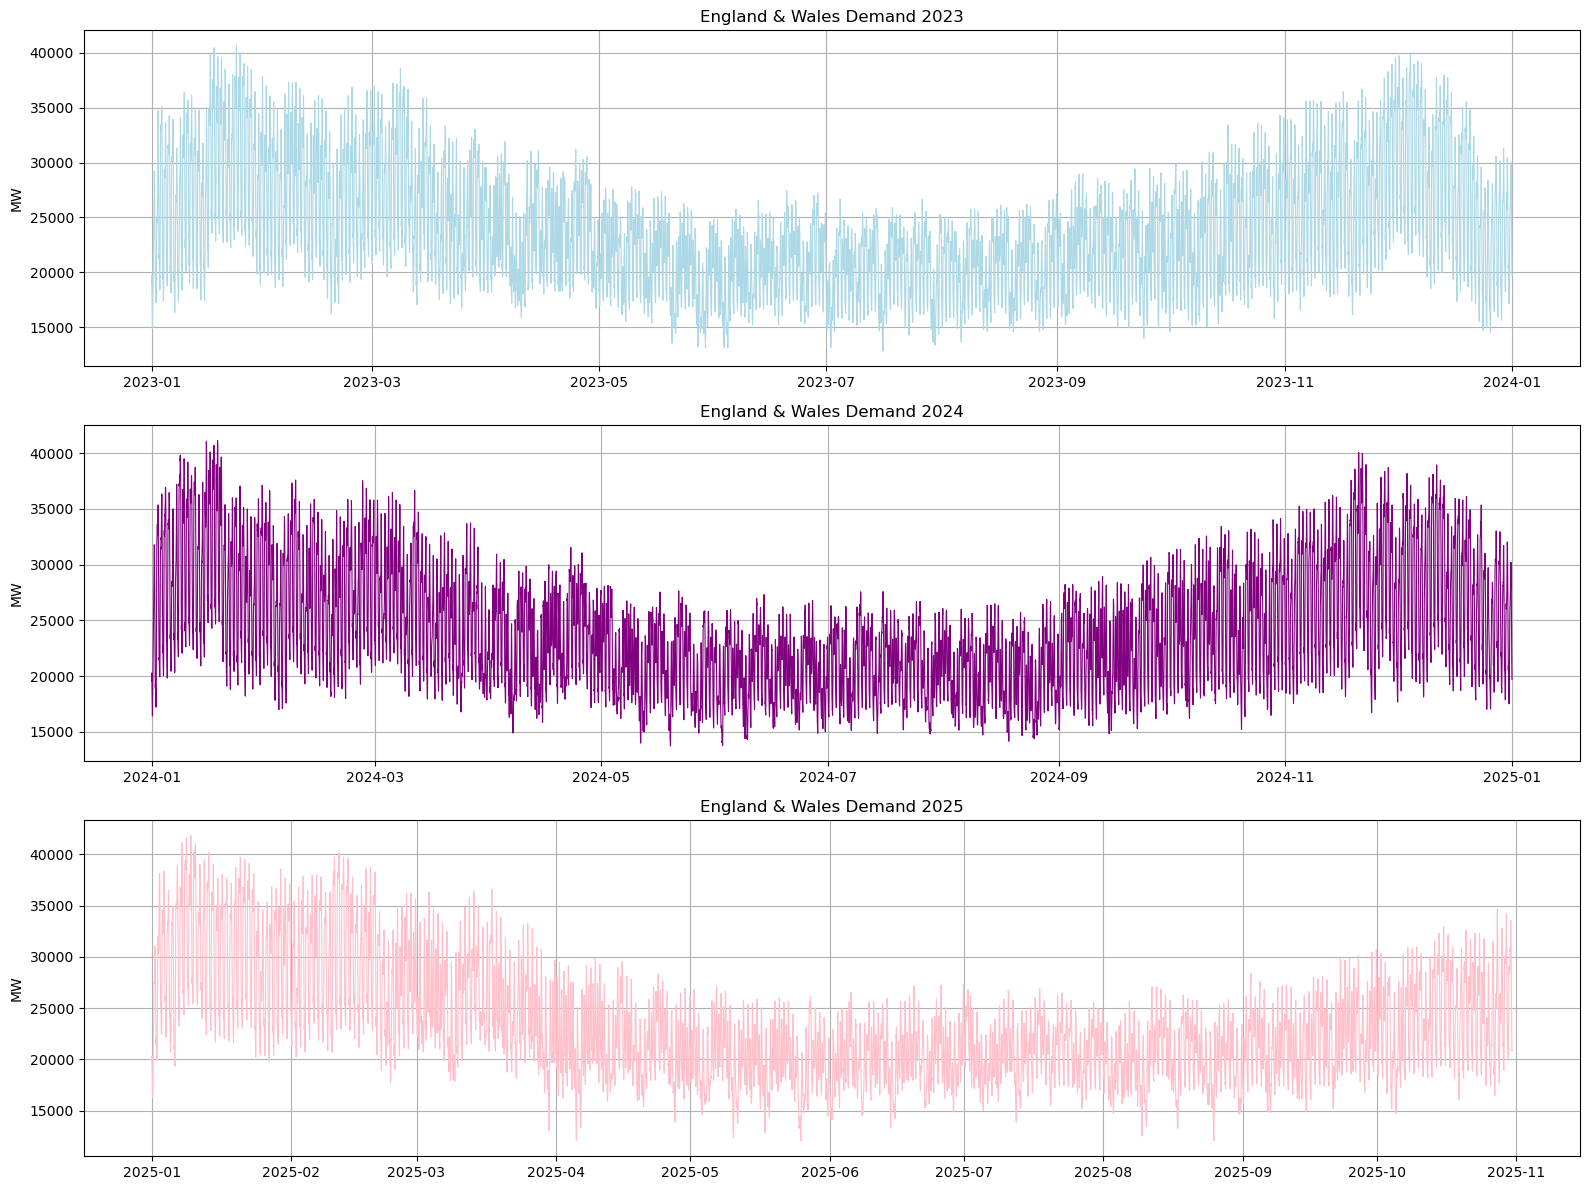

In [15]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [16]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

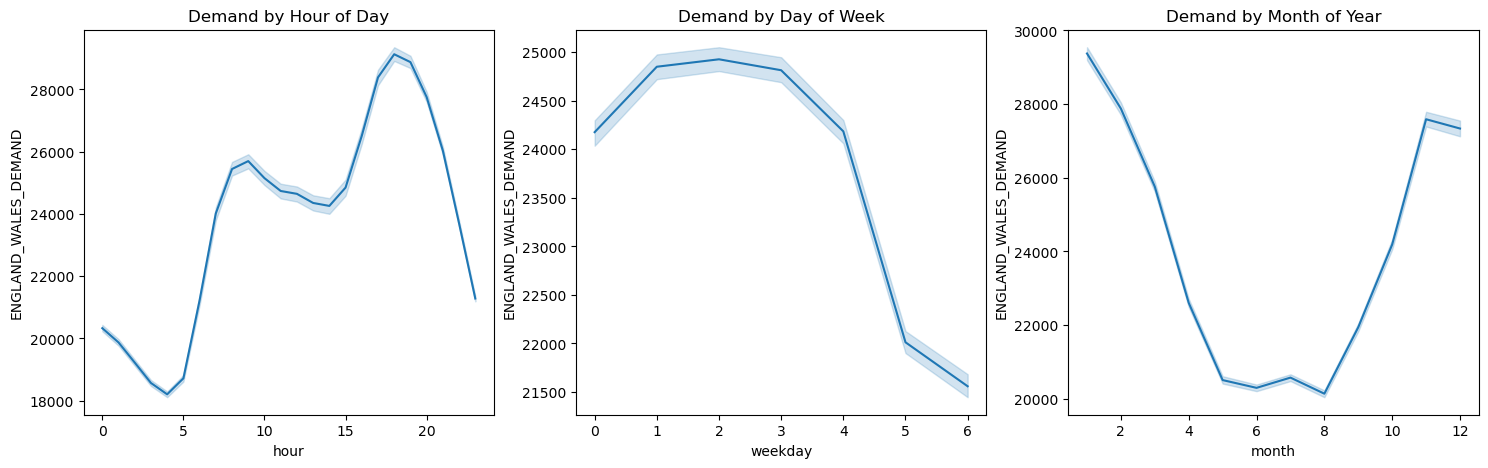

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [18]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

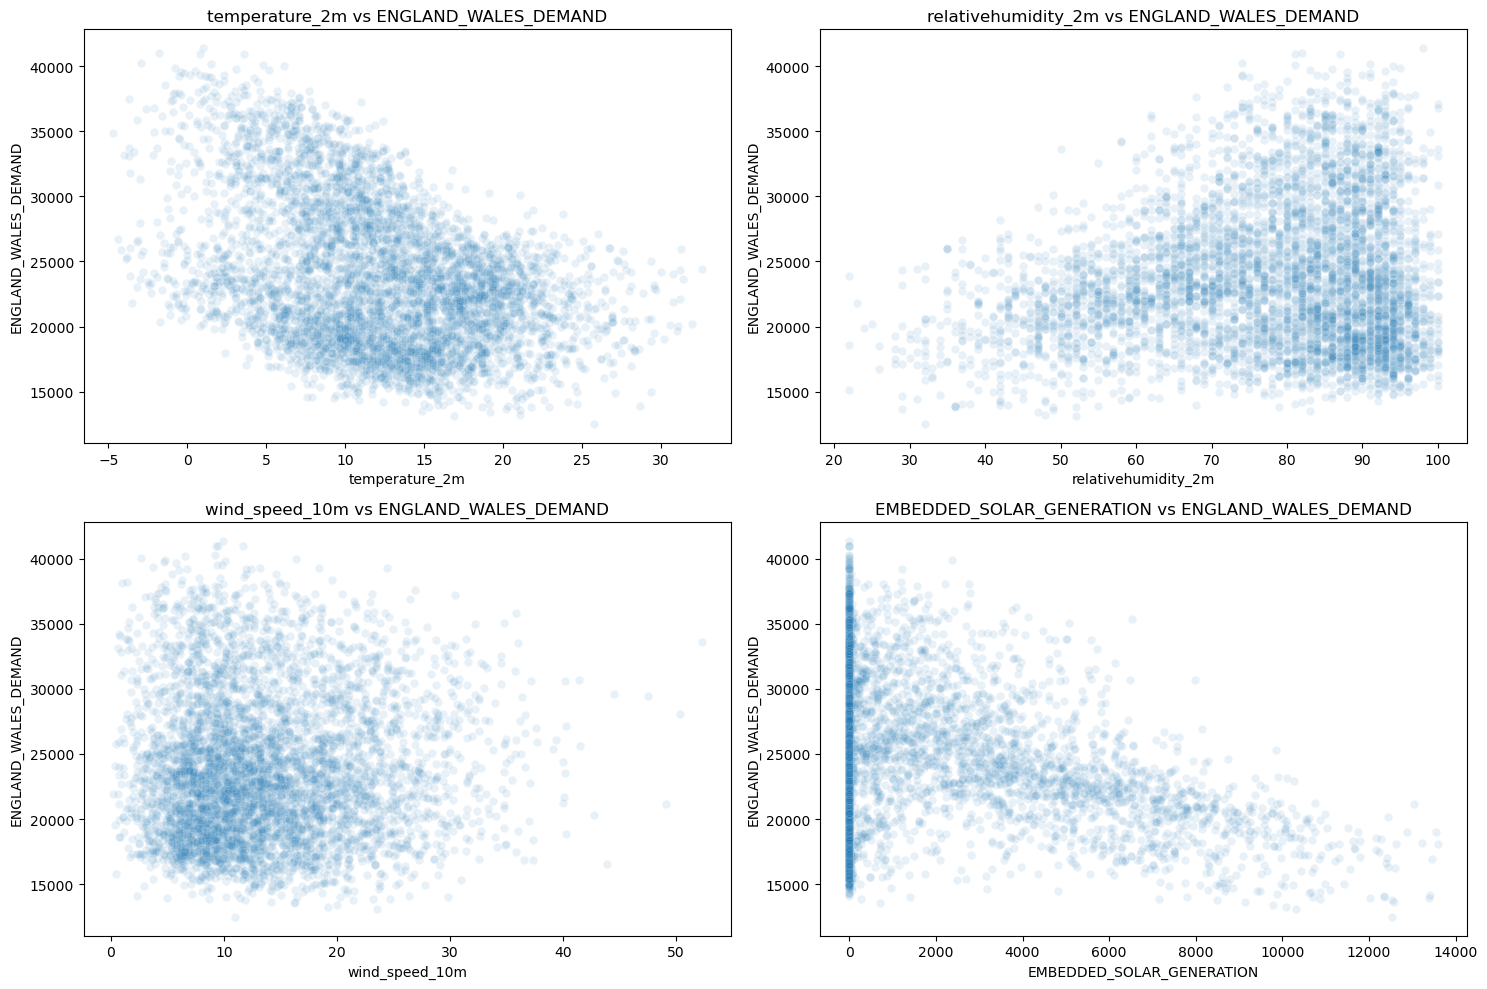

In [19]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()

In [20]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [21]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

In [22]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

In [23]:
# 10. correlation
# check pearson correlation between Demand and weather variables

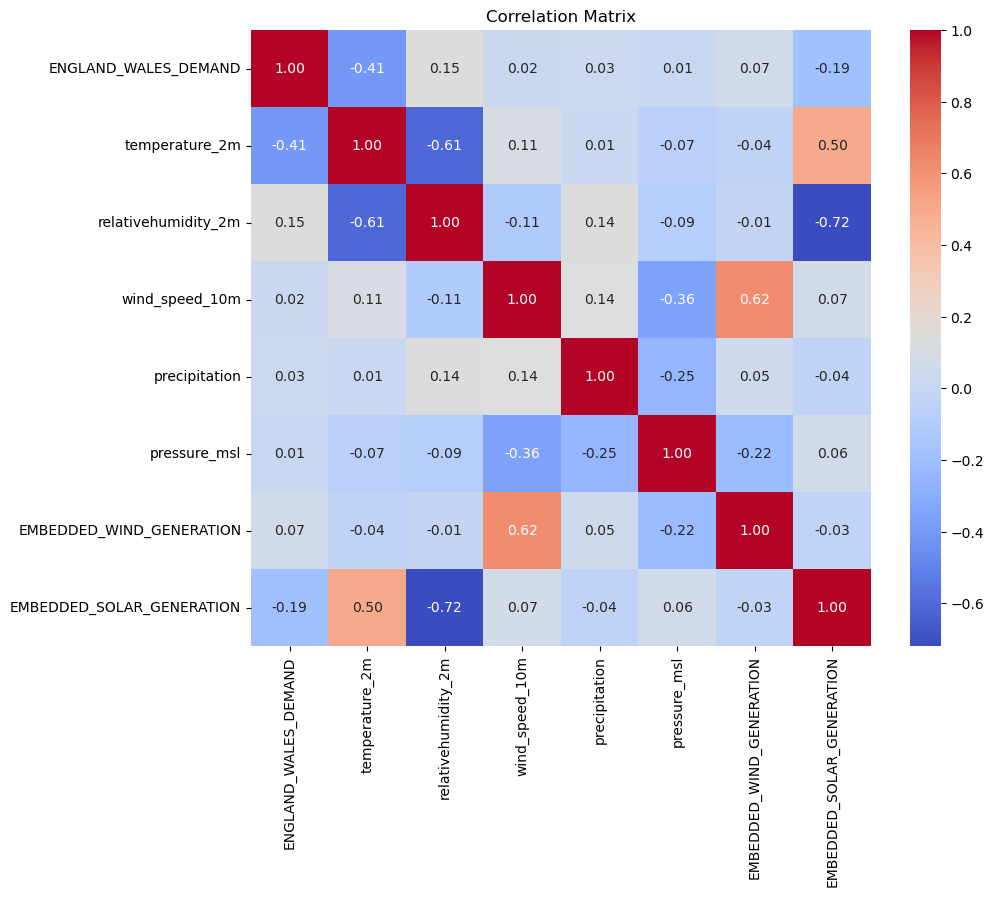

In [24]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [25]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [26]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -2.828960706816038
p-value: 0.05425453386695281
The time series is non-stationary.


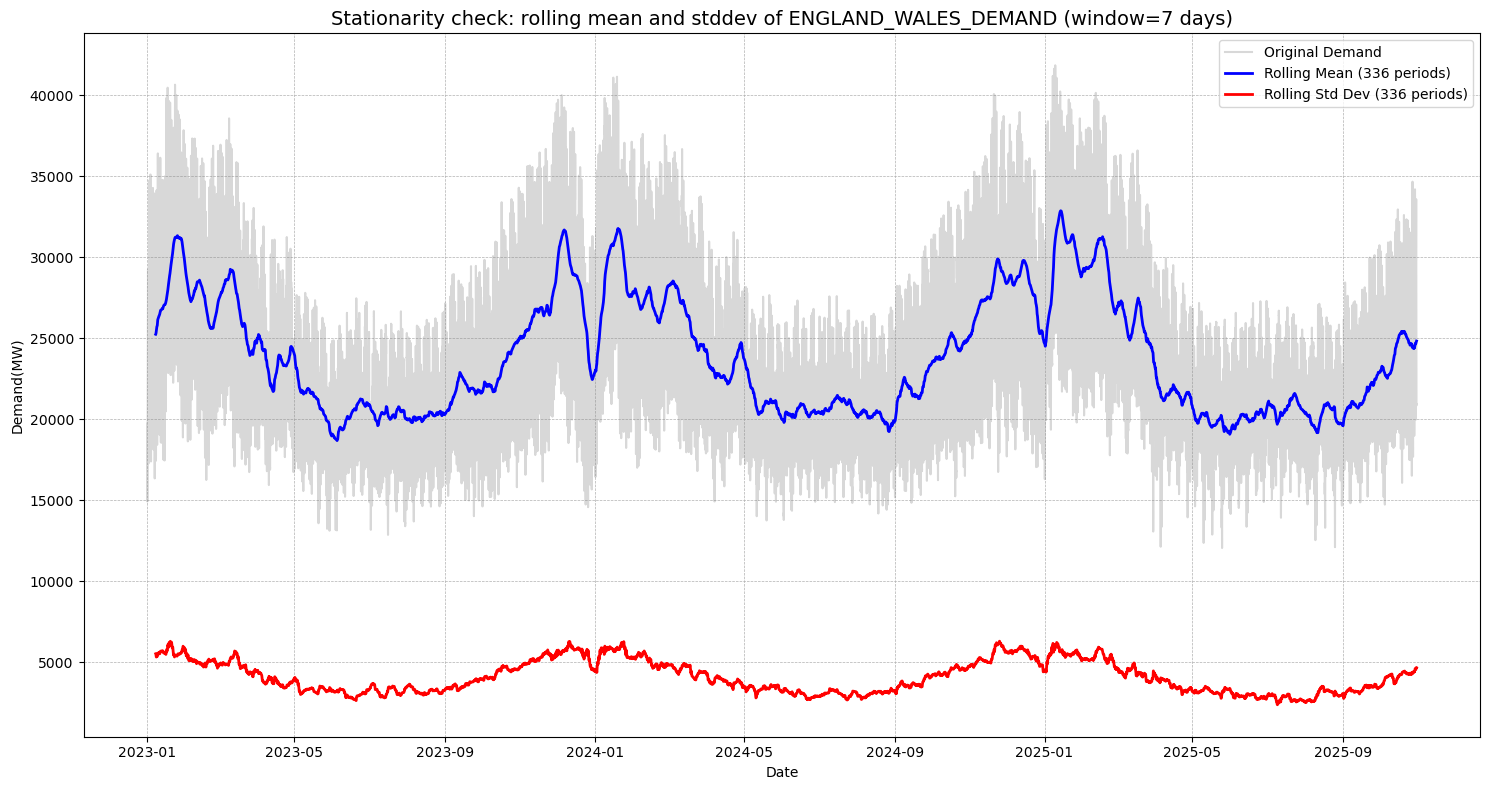

#remark
1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.
2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)
3.seasonality:repeating waves in rolling mean indicate seasonality


In [27]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

## Part A

## Train test split

In [28]:
target = 'ENGLAND_WALES_DEMAND'

# Features
time_features = ['hour', 'day', 'month','year','is_weekend','weekday']
weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl', 
                    'wind_speed_10m', 'wind_direction_10m', 'precipitation']
grid_features = [
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY', 
    'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
    'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
    'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
    'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
    'VIKING_FLOW', 'GREENLINK_FLOW'
]

feature_cols = weather_features + time_features + grid_features

model_df = df.dropna(subset=feature_cols + [target]).copy()

In [29]:
#split based on the date time
#2023，2024
train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime")
print(train_df.head())

#2025
test_df=model_df[model_df.year==2025].sort_values("datetime")
print(test_df.head())

#train set
X_train=train_df[feature_cols]
y_train=train_df[target]

#test set
X_test=test_df[feature_cols]
y_test=test_df[target]

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

  SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND    TSD  ENGLAND_WALES_DEMAND  \
0      2023-01-01                  1  21043  24680                 18995   
1      2023-01-01                  2  21756  25289                 19730   
2      2023-01-01                  3  21348  25269                 19327   
3      2023-01-01                  4  20586  24574                 18589   
4      2023-01-01                  5  19781  24135                 17806   

   EMBEDDED_WIND_GENERATION  EMBEDDED_WIND_CAPACITY  \
0                      2815                    6545   
1                      2793                    6545   
2                      2773                    6545   
3                      2753                    6545   
4                      2712                    6545   

   EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  NON_BM_STOR  ...  \
0                          0                    15037            0  ...   
1                          0                    15037         

## Train Models

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
import warnings
import time
import pickle


models={
    "Linear Regression":LinearRegression(),
     "Random Forest":RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1), 
     "XGBoost":XGBRegressor(n_estimators=100,random_state=42,n_jobs=-1)
}

results_list=[]
predictions={}
for model_name,model in models.items():
    print(f"Training {model_name}...")

    start_train=time.time()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train,y_train)
    end_train=time.time()
    train_time=end_train-start_train

    sample_X = X_test[:1000] if len(X_test) > 1000 else X_test
    start_pred = time.time()
    y_pred=model.predict(X_test)
    end_pred = time.time()
    inference_time = (end_pred - start_pred) / len(sample_X)  # per sample
    full_pred = model.predict(X_test)  # full prediction for metrics
    predictions[model_name] = full_pred

    model_bytes = pickle.dumps(model)
    model_size_mb = len(model_bytes) / 1e6

    mae=mean_absolute_error(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    r2=r2_score(y_test,y_pred)
    mape=mean_absolute_percentage_error(y_test,y_pred)
    
    results_list.append({
        "Model":model_name,
        "MAE":mae,
        "MSE":mse,
        "RMSE":rmse,
        "R2":r2,
        "MAPE":mape,
        "Training Time (s)":train_time,
        "Inference Time per Sample (s)":inference_time,
        "Model Size (MB)":model_size_mb
    })

results_df=pd.DataFrame(results_list)
print("\nModel comparison:")
print(results_df)

Training Linear Regression...
Training Random Forest...
Training XGBoost...

Model comparison:
               Model           MAE           MSE          RMSE        R2  \
0  Linear Regression  13275.744183  2.176312e+08  14752.328599 -6.350826   
1      Random Forest   1224.940842  2.636445e+06   1623.713281  0.910950   
2            XGBoost   1297.089844  2.803615e+06   1674.399818  0.905304   

       MAPE  Training Time (s)  Inference Time per Sample (s)  Model Size (MB)  
0  0.630343           0.074699                       0.000011         0.001415  
1  0.053311          58.927978                       0.000176       318.729031  
2  0.055961           1.978394                       0.000064         0.476161  


## residual plot & time series plot (can use loop to iterate through 3 models to plot graph)

## Feature importance RF/XGB/linear regression

## Part B

## feature engineering

## Hyperparameter tuning